# Poisson分布のベイズ分析
ポアソン分布の確率関数は、
$$
p(x|\lambda) = \frac{\lambda^x e^{-\lambda}}{x!}
$$
である。$\lambda$はポアソン分布の平均であるとともに、分散でもある。

$\lambda$の事前分布としてガンマ分布を仮定する。ガンマ関数の確率密度関数は、
$$
p(x|\alpha, \theta) =
\frac
{x^{\alpha -1} e^{-x/\theta}}
{\Gamma(\alpha) \theta^\alpha}
$$
である。今後$\beta=1/\theta$とし、
$$
p(x|\alpha, \beta) =
\frac
{\beta^\alpha}
{\Gamma(\alpha)}
x^{\alpha-1} e^{-\beta x}
$$
とする。

事前分布のパラメータを$\alpha_0, \beta_0$とすると、ベイズの定理より事後分布は、
$$
\begin{align}
p(\lambda|D) &\propto p(D|\lambda) p(\lambda) \\
&\propto \left( \prod_{i=1}^{n} p(x_i|\lambda) \right) p(\lambda|\alpha_0, \beta_0) \\
&\propto \left( \prod_{i=1}^{n} \lambda^{x_i} e^{-\lambda} \right) \times \lambda^{\alpha_0 -1} e^{-\beta_0 \lambda} \\
&\propto \lambda^{\left(\sum_{i=1}^{n} x_i \right) + \alpha_0 -1} e^{-(n+\beta_0)\lambda}
\end{align}
$$

となる。これは
$$
\begin{align}
\alpha_* &= \alpha_0 + \sum_{i=0}^{n} x_i \\
\beta_* &= \beta_0 + n
\end{align}
$$
としたガンマ分布に等しい。

In [1]:
import scipy.stats as st
import scipy.optimize as opt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

def gamma_hpdi(ci0, alpha, theta, prob):
    def hpdi_conditions(v, a, t, p):
        eq1 = st.gamma.cdf(v[1], a, scale=t) - st.gamma.cdf(v[0], a, scale=t) - p
        eq2 = st.gamma.pdf(v[0], a, scale=t) - st.gamma.pdf(v[1], a, scale=t)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, theta, prob)).x

def poisson_stats(data, a0, b0, prob):
    """
    Input:
        data: data
        a0, b0: parameter of prior
        prob: interval probability
    Returns:
        results: pandas dataframe of posterior
        a_star, b_star: parameter of posterior
    """
    n = data.size
    a_star = data.sum() + a0
    b_star = n + b0
    theta_star = 1./b_star

    mean_lam = st.gamma.mean(a_star, scale=theta_star)
    median_lam = st.gamma.median(a_star, scale=theta_star)
    mode_lam = (a_star - 1.)/b_star
    sd_lam = st.gamma.std(a_star, scale=theta_star)
    ci_lam = st.gamma.interval(prob, a_star, scale=theta_star)
    hpdi_lam = gamma_hpdi(ci_lam, a_star, theta_star, prob)
    stats = np.hstack((mean_lam, median_lam, mode_lam, sd_lam, ci_lam, hpdi_lam)).reshape((1, 8))
    stats_string = ['mean', 'median', 'mode', 'sd', 'ci_low', 'ci_high', 'hpdi_low', 'hpdi_high']
    param_string = ['lambda']
    results = pd.DataFrame(stats, columns=stats_string, index=param_string)
    return results, a_star, b_star

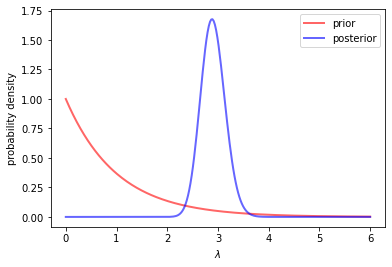

In [5]:
lam = 3.0
n = 50
np.random.seed(99)
data = st.poisson.rvs(lam, size=n)

# prior
a0 = 1.0
b0 = 1.0
prob = 0.95

#calc posterior
results, a_star, b_star = poisson_stats(data, a0, b0, prob)

#plot
fig = plt.figure()
x = np.linspace(0, 6, 250)
plt.plot(x, st.gamma.pdf(x, a0, scale=1./b0), 'r-', lw=2, alpha=0.6, label='prior')
plt.plot(x, st.gamma.pdf(x, a_star, scale=1./b_star), 'b-', lw=2, alpha=0.6, label='posterior')
plt.xlabel(r'$\lambda$')
plt.ylabel('probability density')
plt.legend()
plt.show()

In [6]:
results

,mean,median,mode,sd,ci_low,ci_high,hpdi_low,hpdi_high
lambda,2.901961,2.895427,2.882353,0.23854,2.453271,3.387776,2.440932,3.374032
